In [9]:
# base
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# tunning hyperparamters model
import optuna

In [10]:
train = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/train.csv')
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
test = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
train.groupby('BedroomAbvGr')['SalePrice'].mean()

BedroomAbvGr
0    221493.166667
1    173162.420000
2    158197.659218
3    181056.870647
4    220421.253521
5    180819.047619
6    143779.000000
8    200000.000000
Name: SalePrice, dtype: float64

<BarContainer object of 1460 artists>

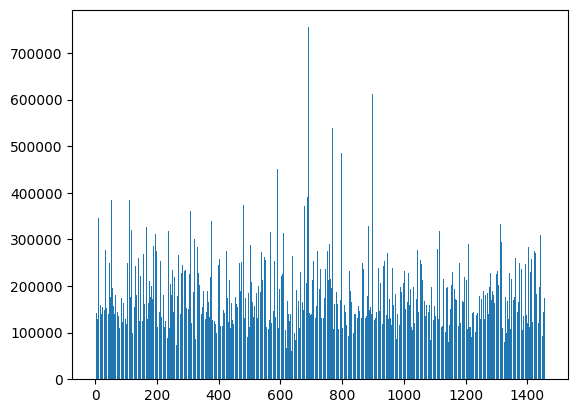

In [13]:
plt.bar(train.index, train['SalePrice'])

In [14]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [15]:
x = train[train['SalePrice'] >= 350000]
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 53 to 1437
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             56 non-null     int64  
 1   MSSubClass     56 non-null     int64  
 2   MSZoning       56 non-null     object 
 3   LotFrontage    53 non-null     float64
 4   LotArea        56 non-null     int64  
 5   Street         56 non-null     object 
 6   Alley          0 non-null      object 
 7   LotShape       56 non-null     object 
 8   LandContour    56 non-null     object 
 9   Utilities      56 non-null     object 
 10  LotConfig      56 non-null     object 
 11  LandSlope      56 non-null     object 
 12  Neighborhood   56 non-null     object 
 13  Condition1     56 non-null     object 
 14  Condition2     56 non-null     object 
 15  BldgType       56 non-null     object 
 16  HouseStyle     56 non-null     object 
 17  OverallQual    56 non-null     int64  
 18  OverallCond   

In [16]:
train_new = train[train['SalePrice'] <= 300000]

In [17]:
train_new['SalePrice'].describe()

count      1345.000000
mean     164246.190335
std       52094.670262
min       34900.000000
25%      128000.000000
50%      156000.000000
75%      196000.000000
max      299800.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

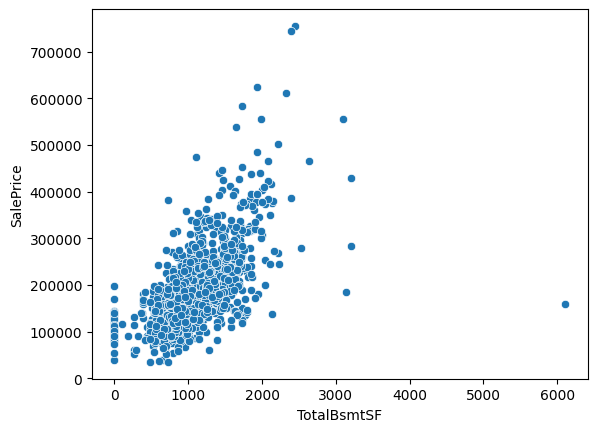

In [18]:
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')

In [19]:
train['TotalBsmtSF'].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [20]:
train_new = train_new[train_new['TotalBsmtSF'] <= 2000]
train_new.info()                  # удалить выбросы по площади подвала

<class 'pandas.core.frame.DataFrame'>
Index: 1334 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1334 non-null   int64  
 1   MSSubClass     1334 non-null   int64  
 2   MSZoning       1334 non-null   object 
 3   LotFrontage    1085 non-null   float64
 4   LotArea        1334 non-null   int64  
 5   Street         1334 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1334 non-null   object 
 8   LandContour    1334 non-null   object 
 9   Utilities      1334 non-null   object 
 10  LotConfig      1334 non-null   object 
 11  LandSlope      1334 non-null   object 
 12  Neighborhood   1334 non-null   object 
 13  Condition1     1334 non-null   object 
 14  Condition2     1334 non-null   object 
 15  BldgType       1334 non-null   object 
 16  HouseStyle     1334 non-null   object 
 17  OverallQual    1334 non-null   int64  
 18  OverallCond  

In [21]:
train_copy = train.copy()

In [22]:
X, y = train_new.drop('SalePrice', axis=1), train_new['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)

In [23]:
# Функция для замены значений "NA" на 0
def replace_na_with_zero(column):
     return column.replace({'NA': 'No', 'nan': 'No', 'None': 'No', np.nan: 'No'})

In [24]:
drop_features = ['Id'] # Эти столбцы считаем не нужными и выкидываем
na_to_zero_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] 


my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('replace_na', FunctionTransformer(replace_na_with_zero), na_to_zero_columns),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Electrical'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [25]:
filled_data = my_imputer.fit_transform(train)
train_copy = my_imputer.fit_transform(train_copy)

In [26]:
filled_data['BsmtQual'].isna().sum()

0

In [27]:
custom_encoding_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical']

category_mapping = {
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 1},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtFinType1': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'BsmtFinType2': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'Heating': {'Floor': 0, 'Grav': 0, 'Wall': 1, 'OthW': 2, 'GasW': 3, 'GasA':4},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}
}

def custom_encode(df):
    for column in df.columns:
        if column in category_mapping:
            df[column] = df[column].map(category_mapping[column])
    return df

In [28]:
ordinal_encoding_columns = ['Foundation']
standard_scaler_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
one_hot_encoding_columns = ['CentralAir']

scaler_and_encoder = ColumnTransformer(
    [
        ('custom_encoding', FunctionTransformer(custom_encode), custom_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)    
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [29]:
train.groupby('Electrical')['SalePrice'].mean()

Electrical
FuseA    122196.893617
FuseF    107675.444444
FuseP     97333.333333
Mix       67000.000000
SBrkr    186825.113193
Name: SalePrice, dtype: float64

In [30]:
train.groupby('FullBath')['SalePrice'].mean()

FullBath
0    165200.888889
1    134751.440000
2    213009.825521
3    347822.909091
Name: SalePrice, dtype: float64

In [31]:
train['Electrical'].value_counts()

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

### from main

In [32]:
# Удаляем неинформативные колонки
drop_features = ['Id', "SaleType","YrSold","MiscVal","3SsnPorch","MoSold","FireplaceQu","MiscFeature","PoolArea", \
                 'Alley', 'MasVnrType', 'Utilities', 'RoofMatl', 'BsmtQual', 'BsmtCond', 'Electrical'] # Alley - тип доступа в переулок (94% пропусков),
# MasVnrType - тип каменной облицовки (59% пропусков)
nan_columns = ['GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence',\
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='median'), ['LotFrontage','MasVnrArea']), # LotFrontage - погонные футы улицыБ соединенные с участком (17% пропусков),
        # MasVnrArea - площадь каменного шпона в квадратных футах
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Electrical','GarageYrBlt'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

In [33]:
ordinal_encoding_columns = ['KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PoolQC',\
                           'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',\
                           'BldgType', 'HouseStyle','RoofStyle','Neighborhood','Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd',\
                           'Foundation', 'ExterQual', 'ExterCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
                           'Heating', 'HeatingQC']
standard_scaler_columns = ['TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
                          'OpenPorchSF','EnclosedPorch','ScreenPorch',\
                          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
one_hot_encoding_columns = ['GarageType','PavedDrive','Fence','SaleCondition', 'CentralAir']


scaler_and_encoder = ColumnTransformer(
    [
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)


In [34]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [35]:
floor_1 = ['1stFlrSF', 'TotalBsmtSF']
floor_2 = ['2ndFlrSF', 'TotRmsAbvGrd', 'GrLivArea']

In [36]:
floor_1_pca = PCA(n_components=1)
floor_2_pca = PCA(n_components=1)

In [37]:
# Определение преобразований для каждого набора столбцов
pca_transformers = [
    ('floor_1_pca', floor_1_pca, floor_1),
    ('floor_2_pca', floor_2_pca, floor_2),
]# Создание ColumnTransformer с PCA преобразованиями
pca_column_transformer = ColumnTransformer(
    transformers=pca_transformers,
    remainder='passthrough'
)

In [38]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('pca', pca_column_transformer)
    ]
)

In [39]:
filled_data = preprocessor.fit_transform(train)

In [40]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['Id', 'SaleType', 'YrSold',
                                                   'MiscVal', '3SsnPorch',
                                                   'MoSold', 'FireplaceQu',
                                                   'MiscFeature', 'PoolArea',
                                                   'Alley', 'MasVnrType',
                                                   'Utilities', 'RoofMatl',
                                                   'BsmtQual', 'BsmtCond',
                                                   'Electrical']),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage',
                                                   'Ma...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'ExterQual',
                                                   'ExterCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC'])],
                                   verbose_feature_names_out=False)),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('floor_1_pca',
                                                  PCA(n_components=1),
                                                  ['1stFlrSF', 'TotalBsmtSF']),
                                                 ('floor_2_pca',
                                                  PCA(n_components=1),
                                                  ['2ndFlrSF', 'TotRmsAbvGrd',
                                                   'GrLivArea'])]))])

In [41]:
selected_columns_3 = ['Heating', 'HeatingQC', 'Electrical','SalePrice']
filled_data_new_3 = filled_data[selected_columns_3]

KeyError: "None of [Index(['Heating', 'HeatingQC', 'Electrical', 'SalePrice'], dtype='object')] are in the [columns]"

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new_3.corr(),  annot=True, fmt='.2f');

In [57]:
selected_columns_3 = ['BsmtFullBath', 'FullBath', 'BsmtHalfBath','HalfBath', 'SalePrice']
filled_data_new_3 = filled_data[selected_columns_3]

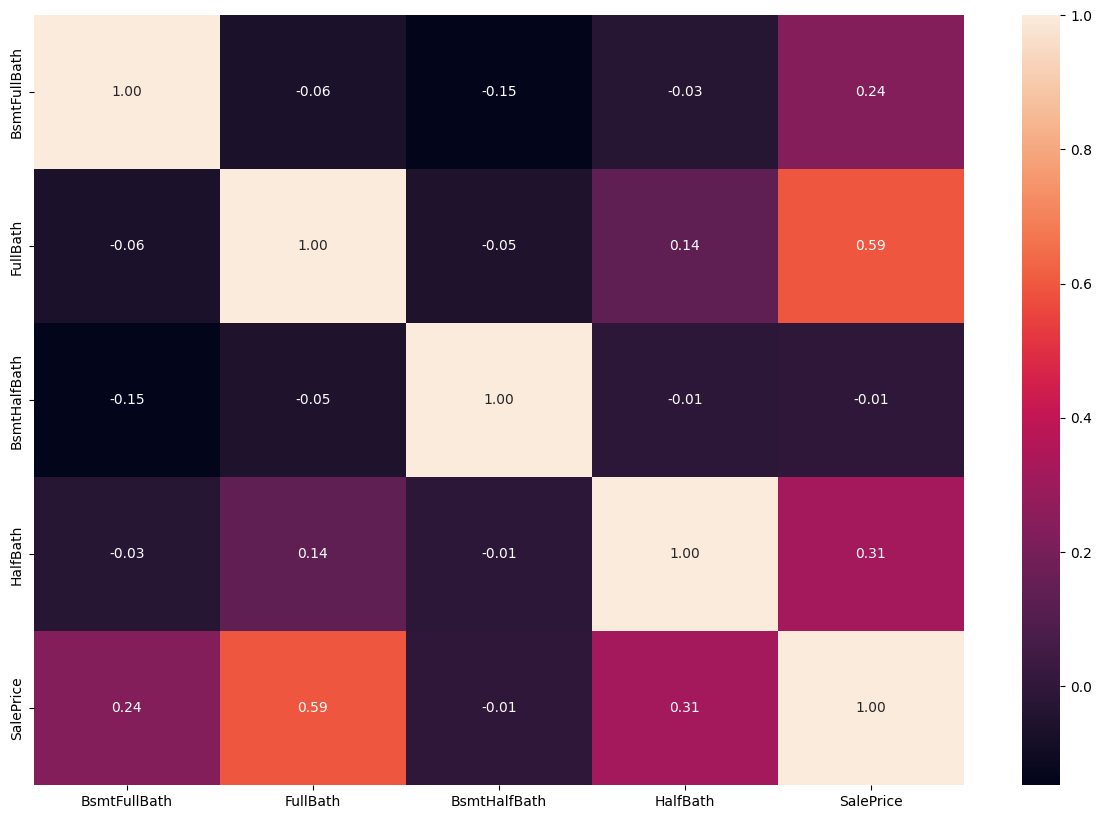

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new_3.corr(),  annot=True, fmt='.2f');

In [205]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [467]:
selected_columns_3 = ['Heating', 'HeatingQC', 'Electrical','SalePrice']
filled_data_new_3 = filled_data[selected_columns_3]

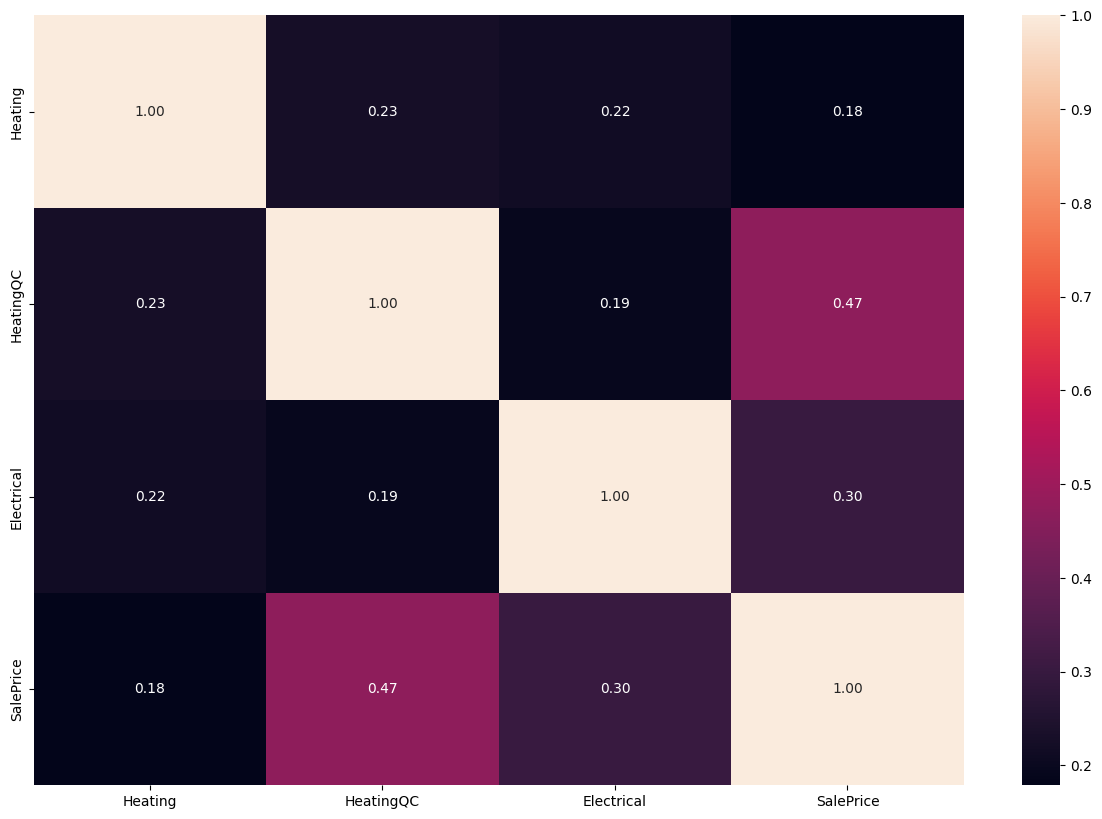

In [468]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new_3.corr(),  annot=True, fmt='.2f');

### from main_new

In [217]:
# Удаляем неинформативные колонки
drop_features = ['Id', "SaleType","YrSold","MiscVal","3SsnPorch","MoSold","FireplaceQu","MiscFeature","PoolArea", \
                 'Alley', 'MasVnrType', 'Utilities', 'RoofMatl', 'BsmtQual', 'BsmtCond', 'Electrical', 'Condition1', \
                 'Condition2', 'Exterior1st', 'Exterior2nd', 'Heating', 'LandSlope', 'Functional', 'ExterQual', 'ExterCond',\
                '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath'] # Alley - тип доступа в переулок (94% пропусков),
# MasVnrType - тип каменной облицовки (59% пропусков)
nan_columns = ['GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence',\
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='median'), ['LotFrontage','MasVnrArea']), # LotFrontage - погонные футы улицыБ соединенные с участком (17% пропусков),
        # MasVnrArea - площадь каменного шпона в квадратных футах
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['GarageYrBlt'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

In [218]:
ordinal_encoding_columns = ['KitchenQual','GarageFinish','GarageQual','GarageCond','PoolQC',\
                           'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', \
                           'BldgType', 'HouseStyle','RoofStyle','Neighborhood', \
                           'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
                           'HeatingQC']
standard_scaler_columns = ['TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
                          'OpenPorchSF','EnclosedPorch','ScreenPorch',\
                          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
one_hot_encoding_columns = ['GarageType','PavedDrive','Fence','SaleCondition', 'CentralAir']


scaler_and_encoder = ColumnTransformer(
    [
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [225]:
floor_1 = ['1stFlrSF', 'TotalBsmtSF']
floor_2 = ['TotRmsAbvGrd', 'GrLivArea']
floor_3 = ['MSSubClass', 'BldgType']
# floor_4 = ['Exterior1st', 'Exterior2nd']  - дропнули

In [226]:
floor_1_pca = PCA(n_components=1)
floor_2_pca = PCA(n_components=1)
floor_3_pca = PCA(n_components=1)
# floor_4_pca = PCA(n_components=1)

In [231]:
# Определение преобразований для каждого набора столбцов
pca_transformers = [
    ('floor_1_pca', floor_1_pca, floor_1),
    ('floor_2_pca', floor_2_pca, floor_2),
    ('floor_3_pca', floor_3_pca, floor_3),
  #  ('floor_4_pca', floor_4_pca, floor_4)
]# Создание ColumnTransformer с PCA преобразованиями
pca_column_transformer = ColumnTransformer(
    transformers=pca_transformers,
    remainder='passthrough'
)

In [240]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
      #  ('pca', pca_column_transformer)
    ]
)

In [23]:
y_train.head()

1165    233170
31      149350
214     161750
902     180000
370     172400
Name: SalePrice, dtype: int64

In [24]:
model = KNeighborsRegressor(n_neighbors=25, p=1, weights='uniform')

In [241]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors=10))
    ]
)

In [265]:
ml_pipeline.steps

[('preprocessor',
  Pipeline(steps=[('imputer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('drop_features', 'drop',
                                                    ['Id', 'SaleType', 'YrSold',
                                                     'MiscVal', '3SsnPorch',
                                                     'MoSold', 'FireplaceQu',
                                                     'MiscFeature', 'PoolArea',
                                                     'Alley', 'MasVnrType',
                                                     'Utilities', 'RoofMatl',
                                                     'BsmtQual', 'BsmtCond',
                                                     'Electrical']),
                                                   ('num_imputer',
                                                    SimpleImputer(strategy='median'),
                                            

In [242]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['Id',
                                                                    'SaleType',
                                                                    'YrSold',
                                                                    'MiscVal',
                                                                    '3SsnPorch',
                                                                    'MoSold',
                                                                    'FireplaceQu',
                                                                    'MiscFeature',
                                                                    'PoolArea',
                                                                    'Alley',
                                                                    'MasVnrType',
                                                                    'Utilities',
                                                                    'RoofMatl',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'Electrical',
                                                                    'Condition1',
                                                                    'Condition2',
                                                                    'Exterior1...
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['KitchenQual',
                                                                    'GarageFinish',
                                                                    'GarageQual',
                                                                    'GarageCond',
                                                                    'PoolQC',
                                                                    'MSZoning',
                                                                    'Street',
                                                                    'LotShape',
                                                                    'LandContour',
                                                                    'LotConfig',
                                                                    'BldgType',
                                                                    'HouseStyle',
                                                                    'RoofStyle',
                                                                    'Neighborhood',
                                                                    'Foundation',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'HeatingQC'])],
                                                    verbose_feature_names_out=False))])),
                ('model', KNeighborsRegressor(n_neighbors=10))])

In [235]:
# Получите предсказания модели
predictions = ml_pipeline.predict(X_train)# Вычислите среднеквадратичную ошибку
mse = mean_squared_error(y_train, predictions)# Вычислите RMSE
rmse = np.sqrt(mse)
print("RMSE модели:", rmse)

RMSE модели: 38902.04582752627


In [236]:
# Получаем предсказания модели на валидационной выборке
# X_valid_preprocessed = preprocessor.transform(X_valid)
y_pred_valid = ml_pipeline.predict(X_valid)# Вычисляем RMSE
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print("RMSE на валидационной выборке:", rmse_valid)


RMSE на валидационной выборке: 45078.677406434304


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [243]:
ml_pipeline_2 = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ]
)

In [244]:
tree = ml_pipeline_2.fit(X_train, y_train)

In [245]:
predictions = ml_pipeline_2.predict(X_train)# Вычислите среднеквадратичную ошибку
mse = mean_squared_error(y_train, predictions)# Вычислите RMSE
rmse = np.sqrt(mse)
print("RMSE модели:", rmse)

RMSE модели: 7449.276283200234


In [246]:
y_pred_valid = ml_pipeline_2.predict(X_valid)# Вычисляем RMSE
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print("RMSE на валидационной выборке:", rmse_valid)

RMSE на валидационной выборке: 21441.06019405584


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [98]:
r = permutation_importance(tree, X_valid, y_valid, n_repeats=30, random_state=0)
importance = pd.Series(dict(zip(X.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)
importance.head(80)

OverallQual    0.430956
GrLivArea      0.141647
TotalBsmtSF    0.022628
GarageCars     0.022302
BsmtFinSF1     0.017868
                 ...   
Electrical     0.000000
Condition1     0.000000
Condition2     0.000000
RoofMatl       0.000000
Id             0.000000
Length: 80, dtype: float64

### new v.2

In [42]:
train = train[train['SalePrice'] <= 300000]
train['SalePrice'].describe()

count      1345.000000
mean     164246.190335
std       52094.670262
min       34900.000000
25%      128000.000000
50%      156000.000000
75%      196000.000000
max      299800.000000
Name: SalePrice, dtype: float64

In [43]:
train = train[train['TotalBsmtSF'] <= 2000]

In [44]:
train['SalePrice'] = np.log(train['SalePrice'])
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [45]:
# Разделим сразу на features и target (таргет у нас test.csv)

X, y = train.drop('SalePrice', axis=1), train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)


In [60]:
# Удаляем неинформативные колонки
drop_features = ['Id', "SaleType","YrSold","MiscVal","3SsnPorch","MoSold","FireplaceQu","MiscFeature","PoolArea", \
                 'Alley', 'MasVnrType', 'Utilities', 'RoofMatl', 'BsmtQual', 'BsmtCond', 'Electrical', 'Condition1', \
                 'Condition2', 'Exterior1st', 'Exterior2nd', 'Heating', 'LandSlope', 'Functional', 'ExterQual', 'ExterCond',\
                '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'MSZoning'] # Alley - тип доступа в переулок (94% пропусков),
# MasVnrType - тип каменной облицовки (59% пропусков)
nan_columns = ['GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence',\
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='median'), ['LotFrontage','MasVnrArea', 'GarageCars', 'GarageArea', 'BsmtFinsF1', 'BsmtFinsF2', \
                                                          'BsmtUnfSF', 'TotalBsmtSF']), # LotFrontage - погонные футы улицыБ соединенные с участком (17% пропусков),
        # MasVnrArea - площадь каменного шпона в квадратных футах
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['GarageYrBlt'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

In [61]:
my_imputer.fit_transform(test)

ValueError: A given column is not a column of the dataframe

In [ ]:
ordinal_encoding_columns = ['KitchenQual','GarageFinish','GarageQual','GarageCond','PoolQC',\
                           'Street', 'LotShape', 'LandContour', 'LotConfig', \
                           'BldgType', 'HouseStyle','RoofStyle','Neighborhood', \
                           'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
                           'HeatingQC']
standard_scaler_columns = ['TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
                          'OpenPorchSF','EnclosedPorch','ScreenPorch',\
                          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
one_hot_encoding_columns = ['GarageType','PavedDrive','Fence','SaleCondition', 'CentralAir']


scaler_and_encoder = ColumnTransformer(
    [
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [ ]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [ ]:
floor_1 = ['1stFlrSF', 'TotalBsmtSF']
floor_2 = ['TotRmsAbvGrd', 'GrLivArea']
floor_3 = ['MSSubClass', 'BldgType']
# floor_4 = ['Exterior1st', 'Exterior2nd']  - дропнули

In [ ]:
floor_1_pca = PCA(n_components=1)
floor_2_pca = PCA(n_components=1)
floor_3_pca = PCA(n_components=1)
# floor_4_pca = PCA(n_components=1)

In [ ]:
# Определение преобразований для каждого набора столбцов
pca_transformers = [
    ('floor_1_pca', floor_1_pca, floor_1),
    ('floor_2_pca', floor_2_pca, floor_2),
    ('floor_3_pca', floor_3_pca, floor_3),
  #  ('floor_4_pca', floor_4_pca, floor_4)
]# Создание ColumnTransformer с PCA преобразованиями
pca_column_transformer = ColumnTransformer(
    transformers=pca_transformers,
    remainder='passthrough'
)

In [ ]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('pca', pca_column_transformer)
    ]
)

In [ ]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ]
)


In [ ]:
tree = ml_pipeline.fit(X_train, y_train)

In [ ]:
predictions = ml_pipeline.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False) # Вычислите RMSE
#print("RMSE модели:", rmse)
np.exp(rmse)

In [56]:
y_pred_valid = ml_pipeline.predict(X_valid)# Вычисляем RMSE
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
#print("RMSE на валидационной выборке:", rmse_valid)
np.exp(rmse_valid)

/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.1610434105432634

In [ ]:
def objective(trial):    # Параметры самой модели
    model_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 10,1),       
        'criterion' : trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
    }  
    ml_pipeline.named_steps['model'].set_params(**model_params)
    study = optuna.create_study(direction='maximize')# Запуск оптимизации
    study.optimize(objective, n_trials=10)# Вывод результатов
best_params = study.best_params
best_value = study.best_valueprint(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение: {best_value}")

In [414]:
ml_pipeline_2 = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors=15))
    ]
)

In [390]:
ml_pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['Id',
                                                                    'SaleType',
                                                                    'YrSold',
                                                                    'MiscVal',
                                                                    '3SsnPorch',
                                                                    'MoSold',
                                                                    'FireplaceQu',
                                                                    'MiscFeature',
                                                                    'PoolArea',
                                                                    'Alley',
                                                                    'MasVnrType',
                                                                    'Utilities',
                                                                    'RoofMatl',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'Electrical',
                                                                    'Condition1',
                                                                    'Condition2',
                                                                    'Exterior1...
                                                                    'HeatingQC'])],
                                                    verbose_feature_names_out=False)),
                                 ('pca',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('floor_1_pca',
                                                                   PCA(n_components=1),
                                                                   ['1stFlrSF',
                                                                    'TotalBsmtSF']),
                                                                  ('floor_2_pca',
                                                                   PCA(n_components=1),
                                                                   ['TotRmsAbvGrd',
                                                                    'GrLivArea']),
                                                                  ('floor_3_pca',
                                                                   PCA(n_components=1),
                                                                   ['MSSubClass',
                                                                    'BldgType'])]))])),
                ('model', KNeighborsRegressor(n_neighbors=15))])

In [391]:
knn = ml_pipeline_2.predict(X_train)

In [392]:
# Получите предсказания модели
predictions_knn = ml_pipeline_2.predict(X_train)# Вычислите среднеквадратичную ошибку
mse = mean_squared_error(y_train, predictions_knn)# Вычислите RMSE
rmse_knn = np.sqrt(mse)
np.exp(rmse_knn)

1.022144608107498

In [393]:
y_pred_valid = ml_pipeline_2.predict(X_valid)# Вычисляем RMSE
rmse_valid_knn = mean_squared_error(y_valid, y_pred_valid, squared=False)
#print("RMSE на валидационной выборке:", rmse_valid)
np.exp(rmse_valid_knn)

/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.0253518286894343

In [415]:
ml_pipeline_cat = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6))
    ]
)

In [416]:
ml_pipeline_cat.fit(X_train, y_train)

0:	learn: 0.0263562	total: 2.14ms	remaining: 425ms
1:	learn: 0.0248465	total: 4.3ms	remaining: 426ms
2:	learn: 0.0236124	total: 6.23ms	remaining: 409ms
3:	learn: 0.0223856	total: 8.22ms	remaining: 403ms
4:	learn: 0.0212389	total: 10.2ms	remaining: 398ms
5:	learn: 0.0201221	total: 12.1ms	remaining: 392ms
6:	learn: 0.0191500	total: 14.1ms	remaining: 389ms
7:	learn: 0.0183700	total: 16ms	remaining: 384ms
8:	learn: 0.0176642	total: 18ms	remaining: 382ms
9:	learn: 0.0169127	total: 20.3ms	remaining: 385ms
10:	learn: 0.0162629	total: 22.2ms	remaining: 382ms
11:	learn: 0.0157013	total: 23.5ms	remaining: 368ms
12:	learn: 0.0151866	total: 25.3ms	remaining: 364ms
13:	learn: 0.0147741	total: 27.2ms	remaining: 362ms
14:	learn: 0.0143205	total: 31.1ms	remaining: 384ms
15:	learn: 0.0139176	total: 34.7ms	remaining: 399ms
16:	learn: 0.0135652	total: 38.8ms	remaining: 417ms
17:	learn: 0.0131793	total: 40.8ms	remaining: 413ms
18:	learn: 0.0128075	total: 43.4ms	remaining: 413ms
19:	learn: 0.0125028	total:

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['Id',
                                                                    'SaleType',
                                                                    'YrSold',
                                                                    'MiscVal',
                                                                    '3SsnPorch',
                                                                    'MoSold',
                                                                    'FireplaceQu',
                                                                    'MiscFeature',
                                                                    'PoolArea',
                                                                    'Alley',
                                                                    'MasVnrType',
                                                                    'Utilities',
                                                                    'RoofMatl',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'Electrical',
                                                                    'Condition1',
                                                                    'Condition2',
                                                                    'Exterior1...
                                                    verbose_feature_names_out=False)),
                                 ('pca',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('floor_1_pca',
                                                                   PCA(n_components=1),
                                                                   ['1stFlrSF',
                                                                    'TotalBsmtSF']),
                                                                  ('floor_2_pca',
                                                                   PCA(n_components=1),
                                                                   ['TotRmsAbvGrd',
                                                                    'GrLivArea']),
                                                                  ('floor_3_pca',
                                                                   PCA(n_components=1),
                                                                   ['MSSubClass',
                                                                    'BldgType'])]))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7ba93ab02dd0>)])

In [417]:
cat = ml_pipeline_cat.predict(X_train)

In [418]:
# Получите предсказания модели
predictions_cat = ml_pipeline_cat.predict(X_train)
rmse_cat = mean_squared_error(y_train, predictions_cat, squared=False)# Вычислите RMSE
np.exp(rmse_cat)

/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.0049563967698307

In [419]:
y_pred_valid_cat = ml_pipeline_cat.predict(X_valid)# Вычисляем RMSE
rmse_valid_cat = mean_squared_error(y_valid, y_pred_valid, squared=False)
#print("RMSE на валидационной выборке:", rmse_valid)
np.exp(rmse_valid_cat)

/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.0127550593803913

In [431]:
np.exp(y_pred_valid_cat).mean()

11.976643986099385

In [432]:
np.exp(y_pred_valid).mean()

11.968560661393301

In [422]:
X_train_prepr = preprocessor.fit_transform(X_train)
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_train, y_train, verbose=False, plot=False)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="RL": Cannot convert 'b'RL'' to float

In [423]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

CatBoostError: Model is not fitted

In [58]:
def objective(trial):    # Параметры самой модели
    model_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 10), #Глубину дерева перебрать от 2 до 10 с шагом 1
        'criterion' : trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
    }    
    ml_pipeline.named_steps['model'].set_params(**model_params)
    #model = ml_pipeline.set_params(**params)    
    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=666, shuffle=True)   
    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(ml_pipeline, X, y, cv=cv, scoring='neg_root_mean_squared_error')    
    RMSE = scores.mean()    
    return RMSE# Создание объекта для проведения оптимизации
study = optuna.create_study(direction='minimize')
# Запуск оптимизации
study.optimize(objective, n_trials=10)# Вывод результатов
best_params = study.best_params
best_value = study.best_value
print(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение: {best_value}")


[I 2024-04-26 09:08:28,575] A new study created in memory with name: no-name-777da439-ad47-45ab-b06e-173da43c4c84
/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/utils/_response.py", line 238, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
  File "/home/saule/miniforge3/lib

ValueError: No trials are completed yet.